PubCrawl Simulation Developer Notebook

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import tqdm
plt.style.use(['science','grid'])

# import custom modules
import Pub
import PubCrawlFunctions as PCF
import Ant

In [2]:
### init the Pubs
# load the Pub CSV
pubsList = np.genfromtxt('Pubs.csv', delimiter=',', dtype=str, skip_header=1)
# init the Pubs 
Pubs = []
for i in range(pubsList.shape[0]):
    pubID = pubsList[i][0]
    openingTime = pubsList[i][1]
    closingTime = pubsList[i][2]
    popularity = pubsList[i][3]
    posX = pubsList[i][4]
    posY = pubsList[i][5]
    # create the Pub
    pub = Pub.Pub(pubID, openingTime, closingTime, popularity, posX, posY)
    Pubs.append(pub)

In [3]:
def showPubMap(Pubs):
    # loop over the Pubs, extract the x and y coordinates and plot them
    x = []
    y = []
    for pub in Pubs:
        x.append(pub.posX)
        y.append(pub.posY)
    plt.scatter(x, y)
    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Pub Map')
    plt.show()
    

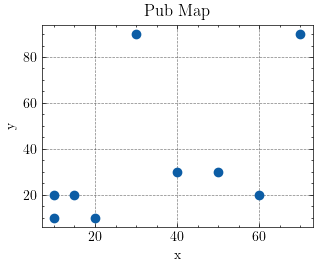

In [4]:
showPubMap(Pubs)

In [5]:
currentTime = 10

# show waiting times for all pubs
for p in Pubs:
    print('Pub ID: ', p.pubID, ' Waiting Time: ', p.getWaitingTime(currentTime))

Pub ID:  1  Waiting Time:  100
Pub ID:  2  Waiting Time:  3
Pub ID:  3  Waiting Time:  93
Pub ID:  4  Waiting Time:  1
Pub ID:  5  Waiting Time:  0
Pub ID:  6  Waiting Time:  0
Pub ID:  7  Waiting Time:  0
Pub ID:  8  Waiting Time:  0
Pub ID:  9  Waiting Time:  0


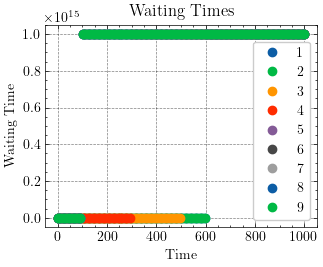

In [6]:
currT = np.linspace(0, 1000, 100)

# evaluate the waiting time for all pubs at different times
for p in Pubs:
    waitingTimes = []
    for t in currT:
        waitingTimes.append(p.getWaitingTime(t))
    plt.plot(currT, waitingTimes, 'o', label=p.pubID)
    plt.xlabel('Time')
    plt.ylabel('Waiting Time')
    plt.title('Waiting Times')
    plt.legend()

# plot wainting times for all pubs in a subplot



# Implementation of the Ant-Colony Optimization

1.) Init the pheromone and visibility matrix


In [7]:
# simulation paramters
tau0 = 1
alpha = 1
beta = 1
gamma = 1 
rho = 0.2

# simulation counters
time = 0
timeMax = int(60*12)            # 12 hours in minutes - 3pm to 3am 
iter = 0
# population size of ants
popSize = 100

# velocity of an ant
velAnt = 1


In [8]:
# init the pheromone matrix which is a 2D array with the size of the number of pubs
pheromoneMatrix = np.ones((len(Pubs), len(Pubs)))
pheromoneMatrix = pheromoneMatrix * tau0


# the visibility matrix is in this case not only the distance between the pubs, but also takes into consideration
# the waiting time at the next pub
# we inititalize the matrix at time = 0

# init the distance matrix D
distanceMatrix = np.zeros((len(Pubs), len(Pubs)))
for i in range(len(Pubs)):
    for j in range(i, len(Pubs)):
        distanceMatrix[i][j] = PCF.getDistance(Pubs[i], Pubs[j])
        #  print("i and j: ", i, j, " distance: ", distanceMatrix[i][j])

        distanceMatrix[j][i] = distanceMatrix[i][j]

# set the diagonal to 10e15
for i in range(len(Pubs)):
    distanceMatrix[i][i] = 10e15

# init the visibility matrix
visibilityMatrix = 1 / distanceMatrix

## Test the ACO without time dependecy, for this set timeMatrix = ones and gamma = 1

New minimum path found, in iteration:  287.4893779721397 1
Path:  [1, 6, 8, 7, 5, 3, 0, 4, 2]


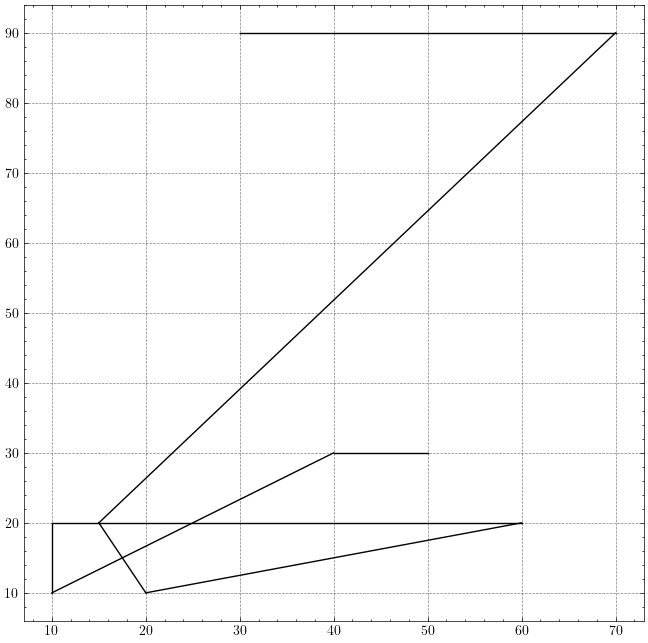

New minimum path found, in iteration:  252.29453436147443 1
Path:  [8, 7, 5, 4, 2, 0, 3, 1, 6]


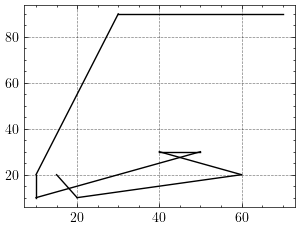

New minimum path found, in iteration:  197.08866638452454 1
Path:  [1, 6, 5, 2, 4, 0, 7, 8, 3]


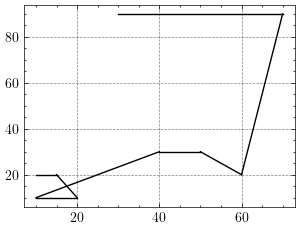

New minimum path found, in iteration:  189.01551218757461 1
Path:  [6, 1, 8, 3, 0, 7, 4, 2, 5]


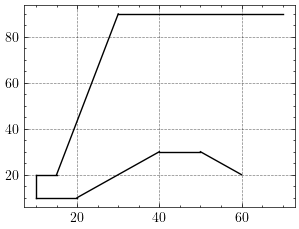

New minimum path found, in iteration:  188.1370849898476 6
Path:  [8, 3, 0, 7, 4, 2, 5, 6, 1]


/Users/felixwaldschock/gits/Chalmers_FFR120_PubCrawl/PubCrawlFunctions.py:176: RuntimeWarning: divide by zero encountered in divide
  deltaPheromonesAnt[i][j] = 1/tourLength
/Users/felixwaldschock/gits/Chalmers_FFR120_PubCrawl/PubCrawlFunctions.py:177: RuntimeWarning: divide by zero encountered in divide
  deltaPheromonesAnt[j][i] = 1/tourLength


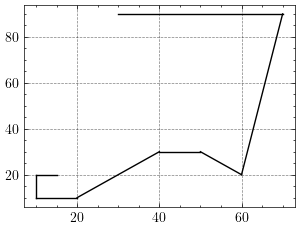

New minimum path found, in iteration:  186.77863777805823 11
Path:  [7, 0, 3, 8, 4, 2, 5, 6, 1]


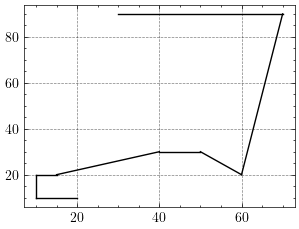

KeyboardInterrupt: 

In [9]:
pathCollection = np.zeros((popSize, len(Pubs)))
pathLengthCollection = np.zeros((popSize, 1))

minimumPathLength = int(10e15)
minimumPath = np.zeros(len(Pubs))

Plotting = True

if Plotting:
        
    # init a plot for the path
    plt.figure(figsize=(8,8))
    plt.title('Pub Crawl')
    plt.xlabel('x')
    plt.ylabel('y')

    # plot all pubs
    x = []
    y = []
    for pub in Pubs:
        x.append(pub.posX)
        y.append(pub.posY)
    plt.scatter(x, y)


while(True):
    iter += 1

    # Generate paths
    for i in range(popSize):
        path = PCF.generatePath(pheromoneMatrix, visibilityMatrix, waitingTimes, alpha, beta, gamma, Pubs)
        pathLength = PCF.getPathLength(path, Pubs)

        # update the minimal path
        if pathLength < minimumPathLength:
            minimumPathLength = pathLength
            minimumPath = path

            # inform the user
            print('New minimum path found, in iteration: ', minimumPathLength, iter)
            print("Path: ", minimumPath)

            if Plotting:
                # plot the path
                plt.clf()
                x = []
                y = []

                for pubID in minimumPath:
                    pub = Pubs[pubID]
                    x.append(pub.posX)
                    y.append(pub.posY)

                # plot the connections between the pubs
                for i in range(len(minimumPath)-1):
                    plt.plot([x[i], x[i+1]], [y[i], y[i+1]], 'k-')
                plt.pause(0.01)



        pathCollection[i,:] = path
        pathLengthCollection[i] = pathLength

    # update the pheromone matrix
    deltaPheromoneMatrix = PCF.getDeltaPheromoneMatrix(pathCollection, pathLengthCollection)
    pheromoneMatrix = PCF.updatePheromoneMatrix(pheromoneMatrix, deltaPheromoneMatrix, rho)



In [ ]:
# start the simulation, the parameters to be optimized is the total time to visit all pubs

# init the ants at random pubs, that open at time = 0 
initialPubs = []
for p in Pubs:
    if p.openingTime == 0:
        initialPubs.append(p)

print('Number of initial pubs: ', len(initialPubs))
print('Initial pubs: ', initialPubs)


while (time<timeMax):
    # init the ants at random pubs, that open at time = 0
    ants = []
    for i in range(popSize):
        ants.append(PCF.Ant(initialPubs[np.random.randint(len(initialPubs))], velAnt))


Number of initial pubs:  6
Initial pubs:  [<Pub.Pub object at 0x104750940>, <Pub.Pub object at 0x104753f10>, <Pub.Pub object at 0x104752f80>, <Pub.Pub object at 0x104752dd0>, <Pub.Pub object at 0x104753040>, <Pub.Pub object at 0x11db9cf70>]


AttributeError: module 'PubCrawlFunctions' has no attribute 'Ant'

In [ ]:
print('Distance Matrix: ', distanceMatrix)

print('Pheromone Matrix: ', pheromoneMatrix)

print('Waiting vector: ', PCF.getWaitingVector(Pubs, time))

print('Waiting vector: ', PCF.getWaitingVector(Pubs, 100))



In [ ]:
a = np.array([1,2,3,4,5])
if 1 in a:
    # return the index of the element
    print(np.where(a==1)[0][0])

0
